In [1]:
import astroprov

from astropy.io import fits
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.table import Table
from astropy.table import Column
from astropy.io import fits
from astropy.io.ascii import SExtractor
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy import wcs

from astroquery.simbad import Simbad

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils import DAOStarFinder
from photutils import CircularAperture
import os
import subprocess

import image_registration
from image_registration import chi2_shift
from image_registration.fft_tools import shift
import pandas

In [2]:
imageDirectory = '/data/mj1e16/kepler/cal/'
dirlist = os.listdir(imageDirectory)
dirlist = [x for x in dirlist if x[0] != '.']
#dirlist = sort(dirlist)
imagelist = [imageDirectory+x for x in dirlist]
#print(dirlist)

In [3]:
def correctExtensionOrder(imageName):
    hdu_list = fits.open(imageName)
    extensionOrder = np.zeros(len(hdu_list))
    for channel in range(1,len(hdu_list)):
        hdr = hdu_list[channel].header
        location = hdr['SKYGROUP'] # independant location
        extensionOrder[location] = channel # ordered from 0-84 channel with extension in place of name
    return extensionOrder

In [4]:
def medianImages(image1,image2,channelOrder1,channelOrder2,outfile): # medianing images 2 at a time as they are large
    image_concat = []
    medianlist = []
    hdu_list_1 = fits.open(image1)
    hdu_list_2 = fits.open(image2)
    for channel in range(1,len(channelOrder1)):
        chanNo1 = int(channelOrder1[channel])
        chanNo2 = int(channelOrder2[channel])
        
        im1 = hdu_list_1[chanNo1].data
        im2 = hdu_list_2[chanNo2].data
        
        yoff,xoff = image_registration.cross_correlation_shifts(im1,im2)
        im1_aligned_to_im2 = np.roll(np.roll(im1,int(yoff),1),int(xoff),0)

        medianImage = np.median([im2,im1_aligned_to_im2],axis=0)
        hdu = fits.PrimaryHDU(medianImage)
        hdu.writeto(outfile+'_{}.fits'.format(channel), clobber=True)
        medianlist.append(outfile+'_{}.fits'.format(channel))
    return outfile

In [17]:
def reMedian(median,image2,channel,channelOrder2,outfile): # medianing images 2 at a time as they are large
    
    image_concat = []
    hdu_list_1 = fits.open(median)
    hdu_list_2 = fits.open(image2)
    chanNo2 = int(channelOrder2[channel])
    im1 = hdu_list_1[0].data
    im2 = hdu_list_2[chanNo2].data
    
    yoff,xoff = image_registration.cross_correlation_shifts(im1,im2)
    im1_aligned_to_im2 = np.roll(np.roll(im1,yoff,1),xoff,0)
    #im1_aligned_to_im2 = np.roll(np.roll(im1,int(yoff),1),int(xoff),0)

    
    medianImage = np.median([im2,im1_aligned_to_im2],axis=0)
    hdu = fits.PrimaryHDU(medianImage)
    hdu.writeto(outfile, clobber=True)
    
    return outfile

In [6]:
def findLowerMagLimit(imagename,cataloguename,magAbove=3,sextractoryDir='/home/mj1e16/sextractor/sextractor-master/config/'):
    os.chdir(sextractoryDir)
    subprocess.call(['sex',imagename])
    assoc = Table.read(cataloguename,format='ascii.sextractor')
    
    print(len(assoc))
    mags = assoc['MAG_BEST'] 
    mags = [x for x in mags if x < 95]
    
    plt.hist(mags,bins='auto')
    plt.show()
    
    minMag = max(mags)
    magLimit = minMag - magAbove
    
    return magLimit

In [7]:
def sextractorTransientSearch(imagename,cataloguename,lowerMag,sextractoryDir='/home/mj1e16/sextractor/sextractor-master/config/'):
    os.chdir(sextractoryDir)
    subprocess.call(['sex',imagename])
    assoc = Table.read(cataloguename,format='ascii.sextractor')

    hdu_list = fits.open(imagename) # open image header
    imagedata = (hdu_list[0].data) 
    
    fig, ax = plt.subplots(figsize=(10, 10))
    positions = (assoc['X_IMAGE'], assoc['Y_IMAGE'])
    apertures = CircularAperture(positions, r=4.)
    norm = ImageNormalize(stretch=SqrtStretch())
    ax.imshow(imagedata, cmap='Greys', origin='lower', vmin=-100,vmax=100)#norm=norm)
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    #plt.savefig('fits.png',dpi=100)
    plt.show()
    
    df = assoc.to_pandas()
    df.drop(df[df['MAG_BEST'] > lowerMag].index)
    #assoc.drop(assoc[assoc.MAG_BEST > lowerMag].index)
    
    plt.hist(df['MAG_BEST'],bins='auto')
    plt.show()
    
    return df

In [8]:
def queryObjectRegion(outputTable,inCat,imageName,searchRadius=5*u.arcsecond):
    imageCoords = []
    r = searchRadius
    
    if inCat == 'dao':
        xlabel = 'xcentroid'
        ylabel = 'ycentroid'
        label = 'id'
        
    if inCat == 'sex':
        xlabel = 'X_IMAGE'
        ylabel = 'Y_IMAGE'
        label = 'NUMBER'
        
    tableLength = len(outputTable)
    for x in range(tableLength):
        xpos = outputTable[xlabel][x]
        ypos = outputTable[ylabel][x]
        if 20 < ypos < 1040:
            if 12 < xpos < 1110:
                imageCoords.append([xpos,ypos])
                # this may need to change per image but I hope not

    coords = load_wcs_from_file(imageName,imageCoords)
    print(coords)
    customSimbad = Simbad()
    customSimbad.add_votable_fields('ra(d)','dec(d)','otype')
    customSimbad.remove_votable_fields('coordinates')
            
    result_table = Table([['-'],[0],[0],['-'],[0],[0]],names=('MAIN_ID','RA_d','DEC_d','OTYPE','xcentroid','ycentroid'),dtype=('object','float64','float64','object','float64','float64'))

    for x in range(len(imageCoords)):
        try:
            c = SkyCoord(coords[x][0],coords[x][1],frame='icrs',unit='deg')
            rt = customSimbad.query_region(c,radius=r)
            rowlist = []
            for y in range(len(rt[0])):
                rowlist.append(rt[0][y])
            rowlist.append(imageCoords[x][0])
            rowlist.append(imageCoords[x][1])
            result_table.add_row(rowlist)

        except:
            result_table.add_row(['N/A',[0],[0],'Not Found in Simbad',[imageCoords[x][0]],[imageCoords[x][1]]])
    
    
    return result_table

In [9]:
def alterDefault(defaultDir,valList,attributeList):
    
    with open(defaultDir+'/default.sex','r') as f:
        data  = f.read()
    for x in range(len(valList)):
        nameLoc = data.find(attributeList[x]) + len(attributeList[x])
        endLoc = data[nameLoc:].find('#') + nameLoc
        newData = data[:nameLoc] + ' '+str(valList[x])+' ' + data[endLoc:]
        data = newData
    
#     with open(defaultDir+'/default.sex','r') as f:
#         endData = f.read()
#     cname = 'CATALOG_NAME'
#     nameLoc = endData.find(cname) + len(cname)
#     endLoc = data[nameLoc:].find('#') + nameLoc
#     newData = data[:nameLoc] + '' + data[endLoc:]
    
    with open(defaultDir+'/default.sex','w') as f:
        f.write(data)

In [10]:
def load_wcs_from_file(filename,pixCoord):
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
    #print(w.wcs.name)

    # Print out all of the settings that were parsed from the header
    w.wcs.print_contents()

    # Three pixel coordinates of interest.
    # Note we've silently assumed a NAXIS=2 image here.
    # Note also that the pixel coordinates are pairs of [X, Y], 
    # and since WCS built from FITS header automatically has
    # origin set to 1, [0, 0] is actually not inside the image.
    pixcrd = np.array(pixCoord, dtype=np.float_)

    # Convert pixel coordinates to world coordinates
    # The second argument is "origin" -- in this case we're declaring we
    # have 1-based (Fortran-like) coordinates.
    world = w.wcs_pix2world(pixcrd, 1)
    #print(world)
    return(world)
#     # Convert the same coordinates back to pixel coordinates.
#     pixcrd2 = w.wcs_world2pix(world, 1)
#     print(pixcrd2)

#     # These should be the same as the original pixel coordinates, modulo
#     # some floating-point error.
#     assert np.max(np.abs(pixcrd - pixcrd2)) < 1e-6




In [11]:
def findObjectOccurences(inputTable,columnName):
    otype = inputTable[columnName]
    otypelist = []
    for x in range(len(otype)):
        otypelist.append(otype[x])
    #print(len(otypelist))
    newotype = set(otypelist)
    counter = collections.Counter(otypelist)
    keys = counter.keys()
    values = counter.values()
    occurenceDict = dict(zip(keys,values))
    od = collections.OrderedDict(sorted(occurenceDict.items()))
    return od

In [12]:
alterDefault('/home/mj1e16/sextractor/sextractor-master/config/',[5,5,64,3],['DETECT_THRESH','DETECT_MINAREA','BACK_SIZE','BACK_FILTERSIZE'])

In [12]:
extensionOrders = []
for image in imagelist:
    extensionOrders.append(correctExtensionOrder(image))

In [13]:
medianDir = '/data/mj1e16/kepler/newDiff/'
medians = os.listdir(medianDir)
medians = [x for x in medians if x[0] != '.']
medians.sort()

In [14]:
####### ONLY WHEN RECOMPUTING IMAGES #############

# medianImages(imagelist[0],imagelist[1],extensionOrders[0],extensionOrders[1],'/data/mj1e16/kepler/newDiff/median')

# for imageNo in range(2,len(imagelist)):
#     for channel in range(1,len(medians)):
#         medianFile = medianDir+'median_{}.fits'.format(channel)
#         reMedian(medianFile,imagelist[imageNo],channel,extensionOrders[imageNo],medianFile)
        
# os.chdir('/data/mj1e16/kepler/hotpants-master/')
# for imNo in range(len(imagelist)):
#     for channel in range(1,len(medians)):
#         ccdChannel = int(extensionOrders[imNo][channel])
#         inim = imagelist[imNo]+'[{}]'.format(ccdChannel)
#         tmplim = medianDir+'median_{}.fits'.format(channel)
#         outim = '/data/mj1e16/kepler/properDiff/diff_imNo{}_channel{}.fits'.format(imNo,channel)
#         subprocess.call(['./hotpants','-inim',inim,'-tmplim',tmplim,'-outim',outim,'-v','0'])

9763


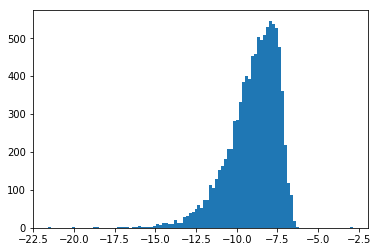

9424


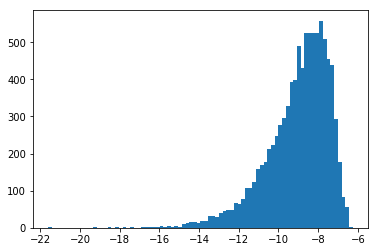

7535


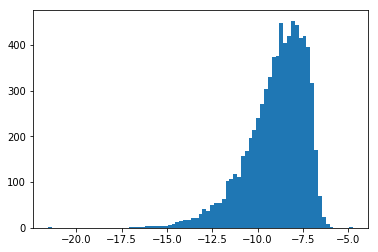

7328


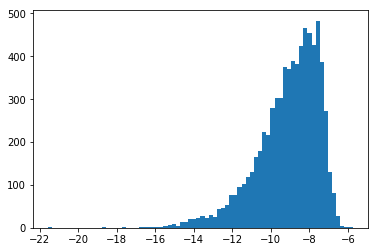

7232


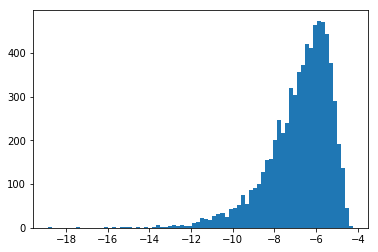

6859


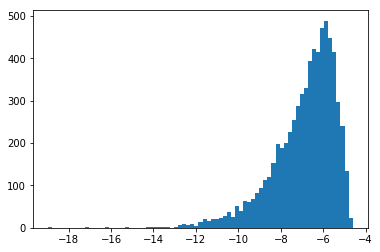

5186


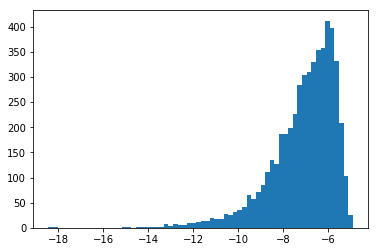

5746


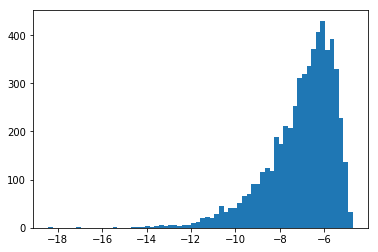

9750


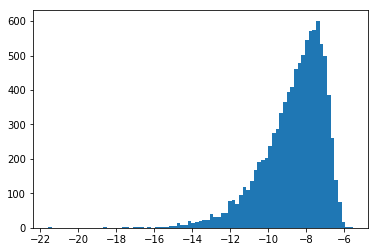

8831


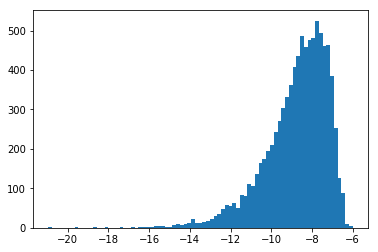

7822


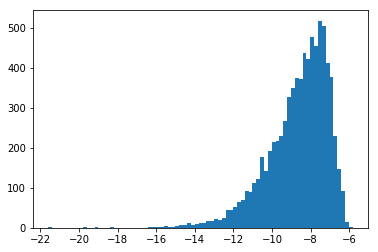

8843


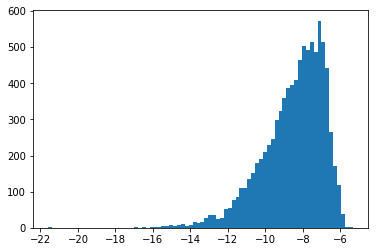

10495


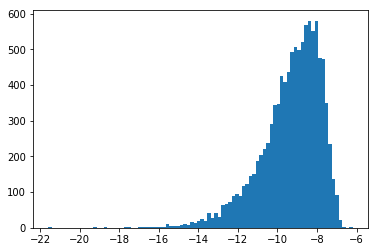

9463


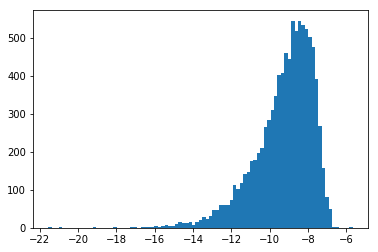

8461


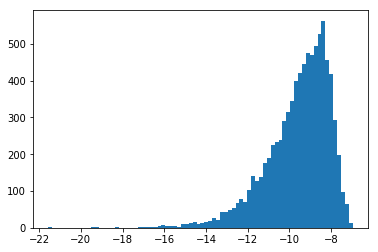

9664


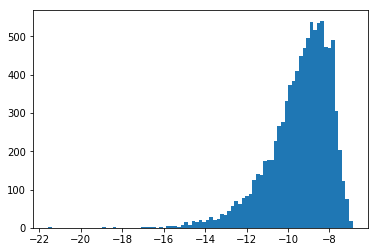

12591


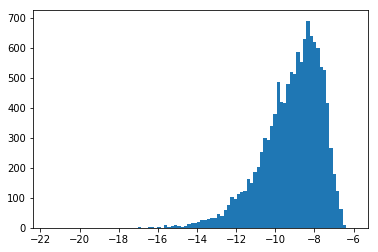

11886


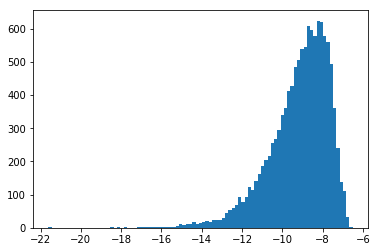

11596


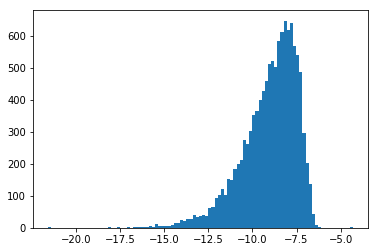

11657


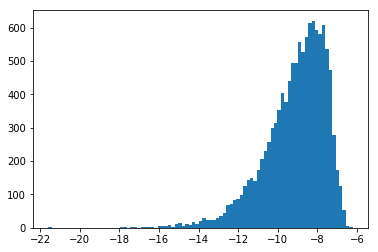

11706


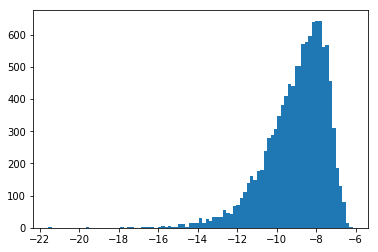

11482


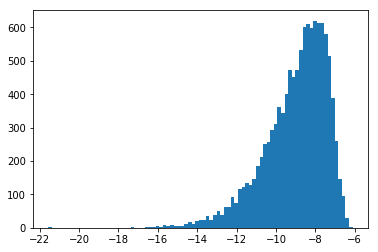

9666


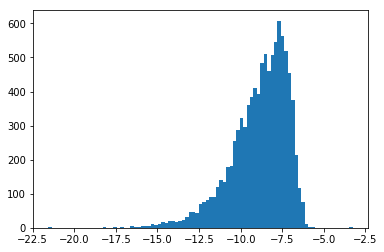

10508


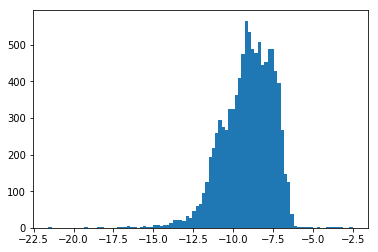

10296


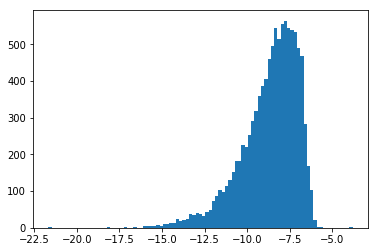

10073


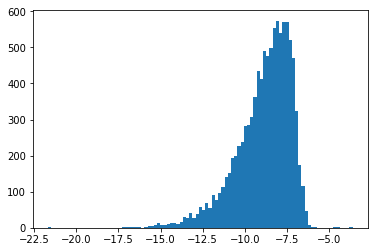

9681


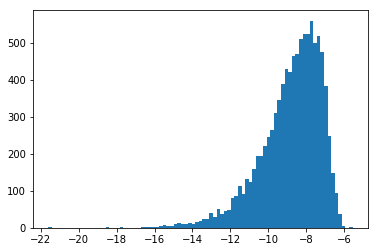

9120


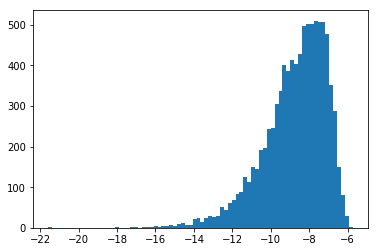

8672


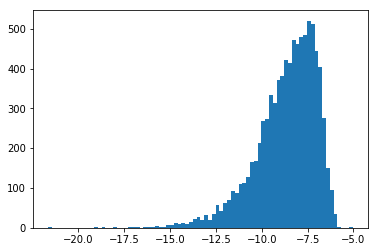

8612


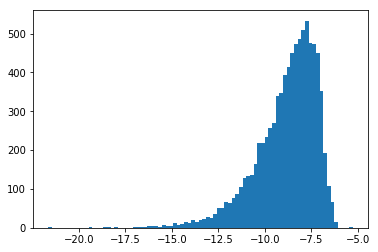

8268


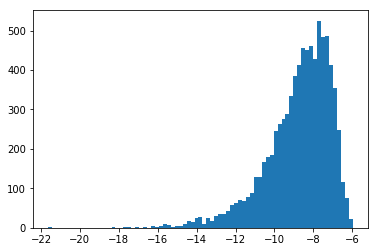

7509


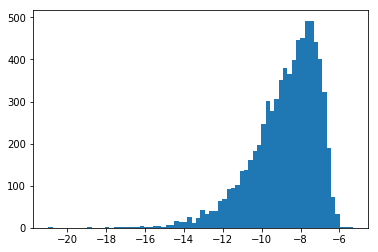

11401


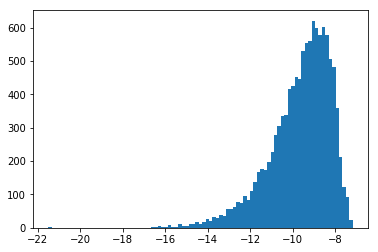

11352


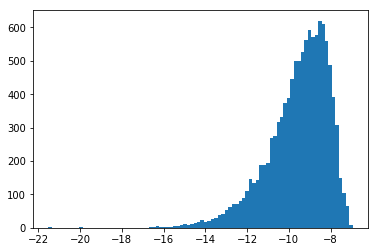

10505


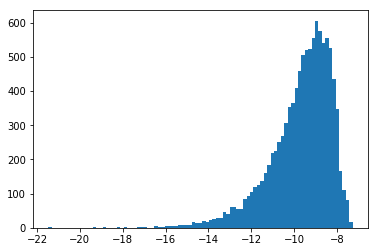

10626


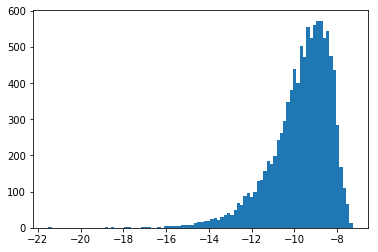

10357


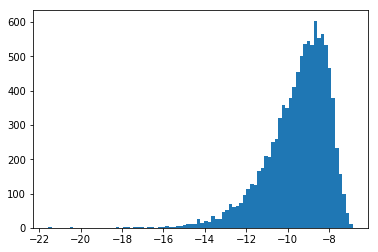

9915


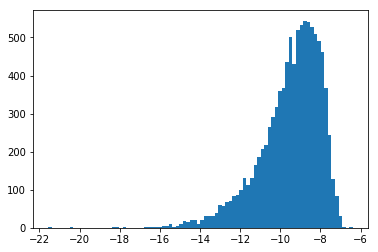

11276


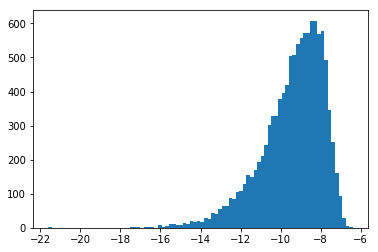

11244


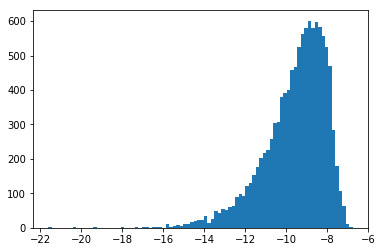

10705


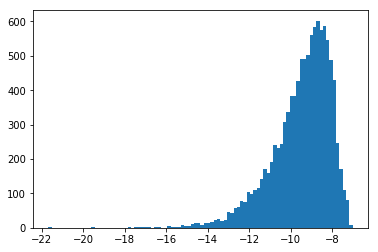

10837


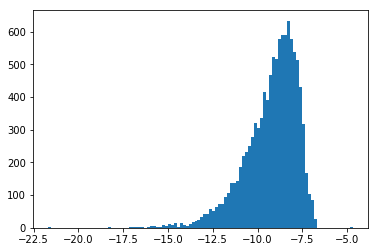

10971


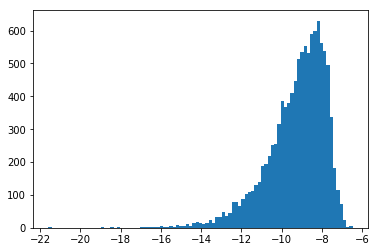

10995


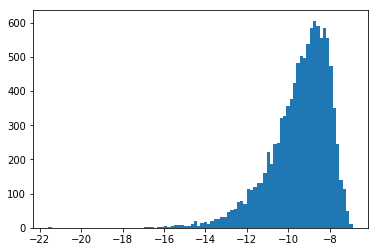

9921


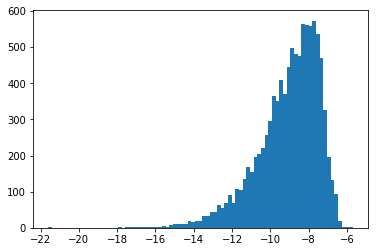

11114


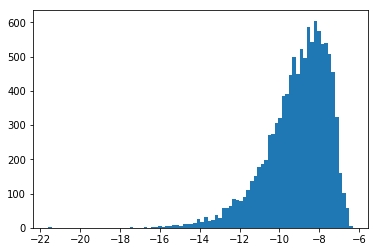

10796


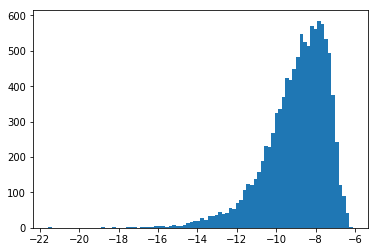

10728


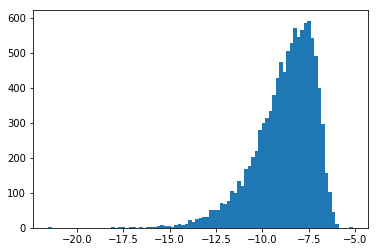

9967


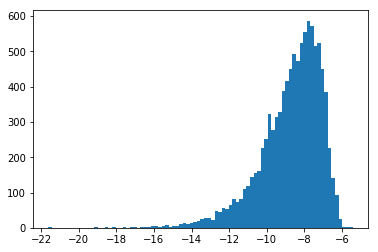

10474


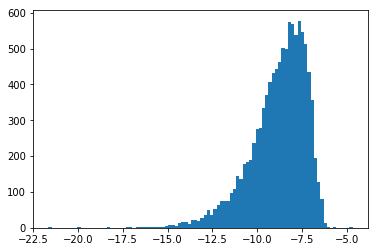

8105


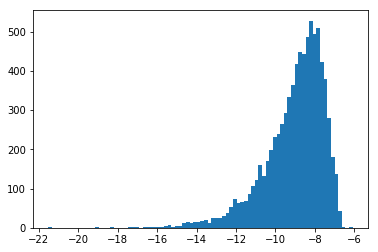

8436


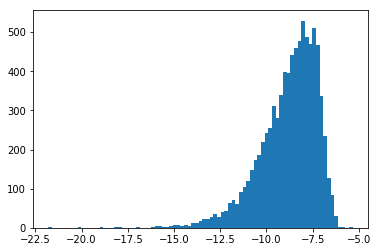

9180


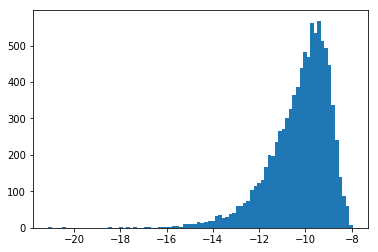

9550


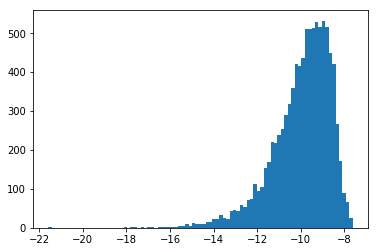

7843


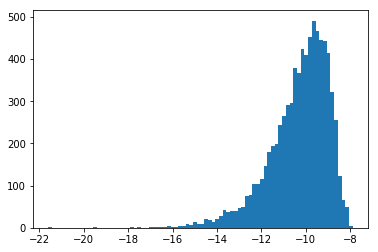

7208


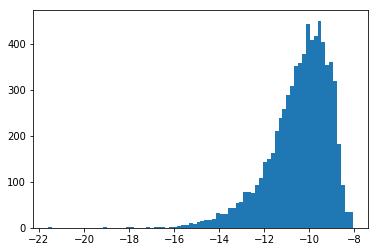

11711


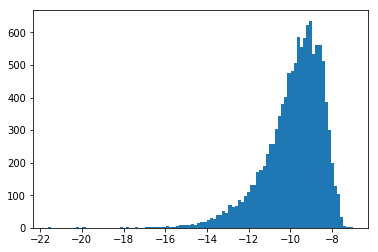

11744


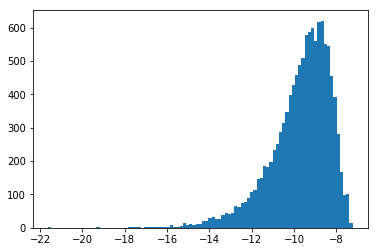

10930


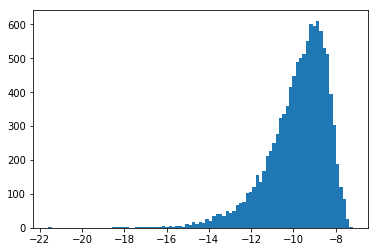

11103


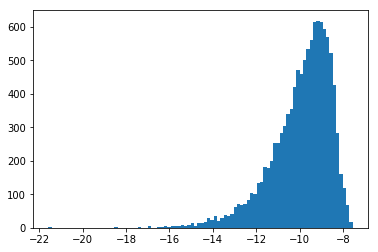

11945


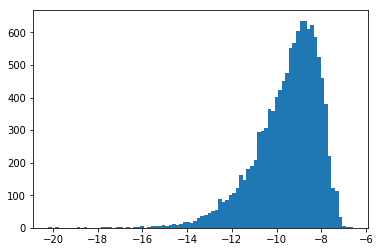

11595


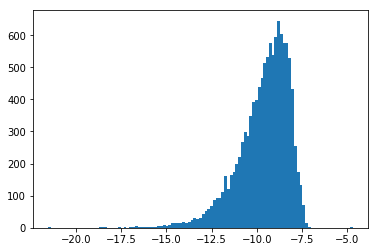

13033


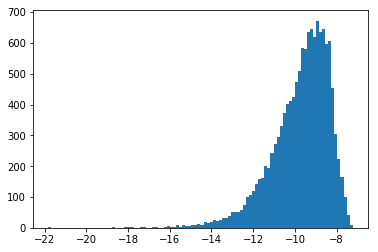

12480


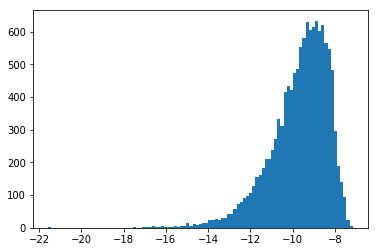

11297


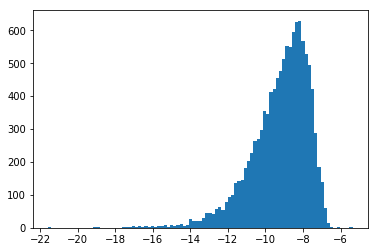

11038


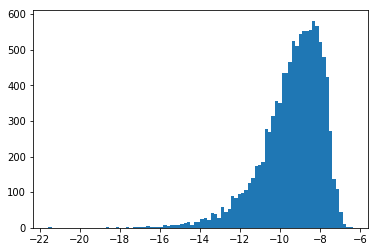

13157


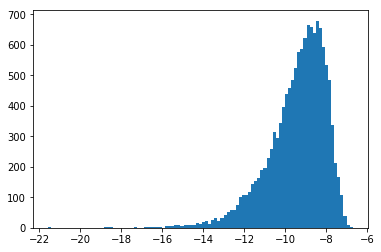

12195


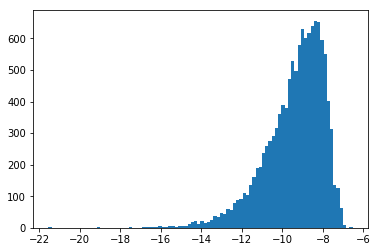

10455


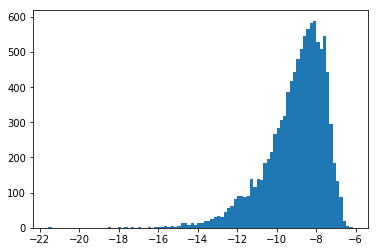

9833


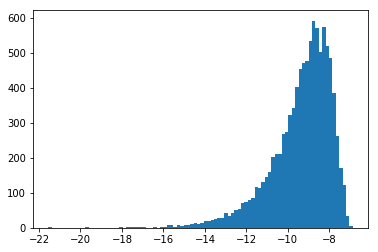

8782


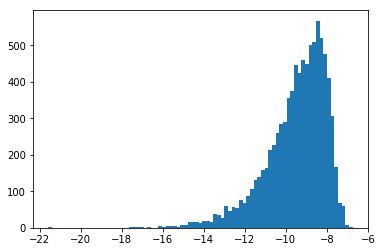

9293


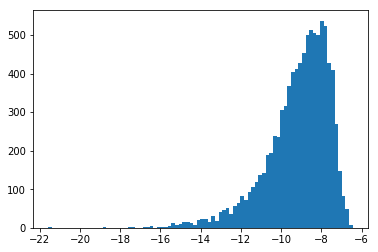

11169


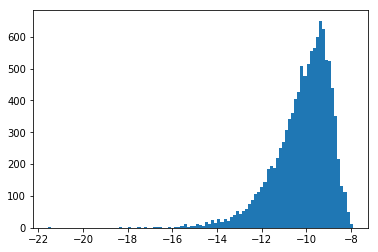

9330


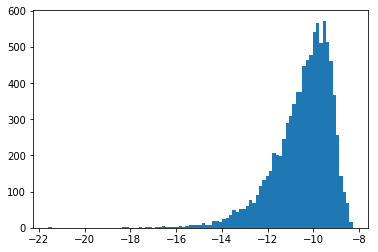

10024


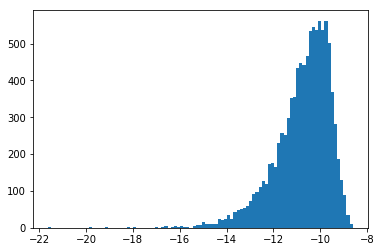

9078


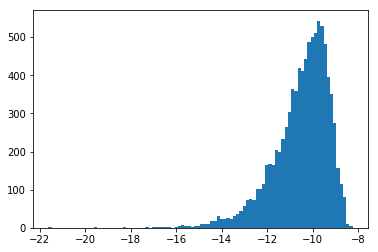

10914


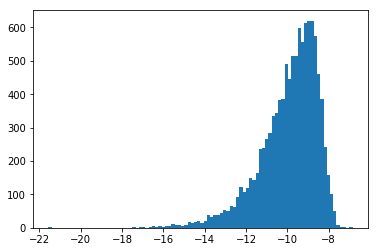

11026


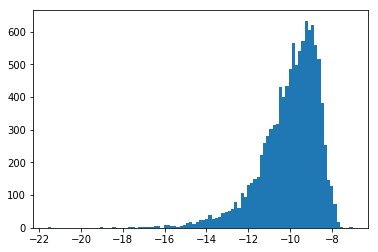

10602


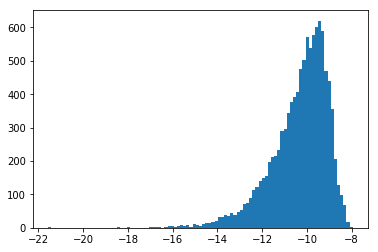

9980


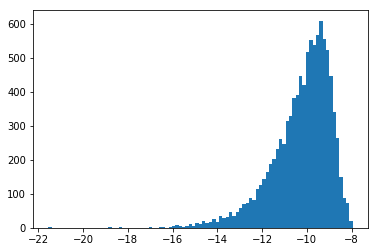

11514


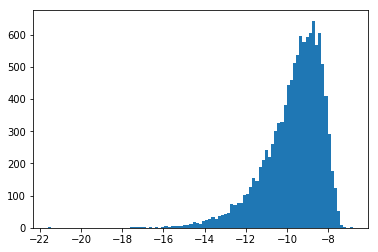

11989


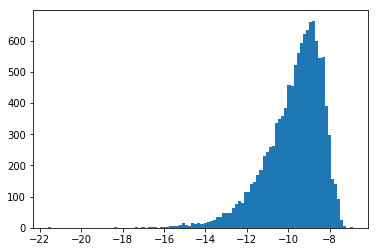

11433


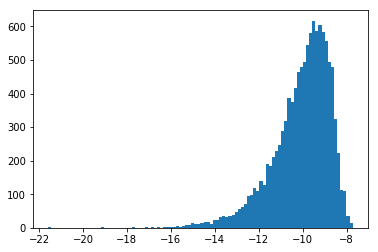

-9.19983373494


In [15]:
lowerMagLims = []
for channel in range(1,len(medians)):
    lowerMagLims.append(findLowerMagLimit(medianDir+'median_{}.fits'.format(channel),'test.cat'))
    
lowMagLim = np.mean(lowerMagLims)
print(lowMagLim)

In [16]:
newlist = [0] # correct as median 0 does not exist
newlist.extend(lowerMagLims)

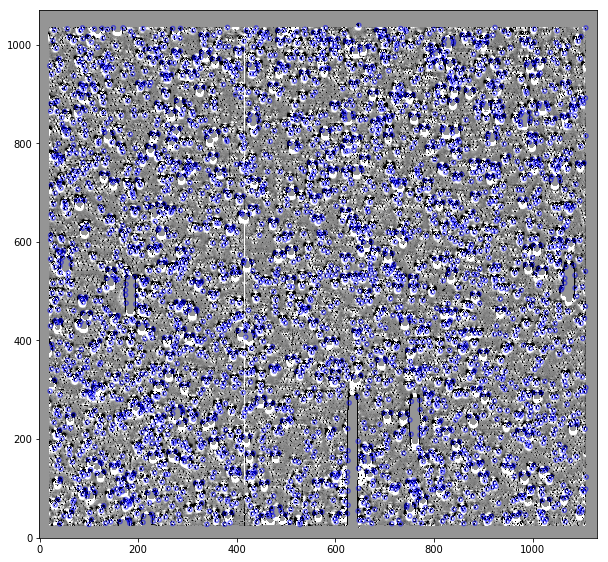

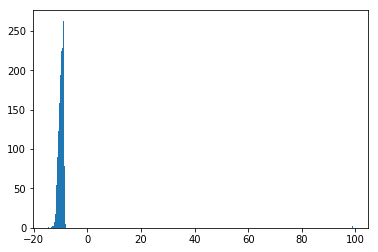

[[ 291.14154333   50.21634032]
 [ 291.18556745   50.17398335]
 [ 291.05383599   50.30551075]
 ..., 
 [ 290.20704398   51.05663052]
 [ 290.35569023   51.12367809]
 [ 290.64836415   51.2440234 ]]


/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '19:25:37.3891 +50:15:15.7186': No astronomical object found :
  (error.line, error.msg))
/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '19:25:15.7468 +50:13:20.3595': No astronomical object found :
  (error.line, error.msg))
/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '19:24:08.818 +50:05:16.8881': No astronomical object found :
  (error.line, error.msg))
/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/ast

In [ ]:
objectsFound = []

for imNo in range(len(imagelist)):
    for channel in range(1,2): #len(medians)):
        magLim = lowerMagLims[channel]
        diffImName = '/data/mj1e16/kepler/properDiff/diff_imNo{}_channel{}.fits'.format(imNo,channel)
        brightTrans = sextractorTransientSearch(diffImName,'test.cat',magLim)
        if len(brightTrans) > 0:
            result_table = queryObjectRegion(brightTrans,'sex',diffImName)
            objectsFound.append(findObjectOccurences())
            

In [23]:
functools.reduce(operator.add, map(collections.Counter, objectsFound))

,NUMBER,EXT_NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_BEST,BACKGROUND,THRESHOLD,FLUX_MAX,XPEAK_IMAGE,YPEAK_IMAGE,X_IMAGE,Y_IMAGE,FWHM_IMAGE,ELLIPTICITY
0,1,1,143917.600,639.8785,-13.0512,6.000044,228.528,3473.9910,647,110,647.0416,99.8364,25.39,0.946
1,2,1,100579.200,461.6040,-12.6037,1.912924,228.528,3774.7450,646,53,646.1707,53.7858,14.83,0.846
2,3,1,585344.000,1045.2500,-14.4989,5.428112,228.528,5160.4200,646,152,646.3025,195.1901,33.55,0.977
3,4,1,180560.300,751.0197,-12.8338,6.686670,228.528,2455.8340,630,287,628.1340,273.2393,37.12,0.960
4,5,1,70408.570,502.7616,-11.0355,1.441609,228.528,5861.5690,624,54,624.6146,48.5795,21.14,0.851
5,6,1,72357.160,508.9561,-12.3802,5.695269,228.528,3919.4330,626,103,625.9633,94.4075,17.93,0.943
6,7,1,41342.690,309.9905,-11.5657,-0.056250,228.528,4311.3110,230,32,230.5236,32.9999,10.20,0.804
7,8,1,48074.270,303.1767,-11.7223,-0.223872,228.528,4741.7550,211,28,209.9736,30.7232,9.83,0.745
8,9,1,42210.640,313.3418,-11.3779,-0.189218,228.528,3488.8210,164,34,163.3403,32.4995,9.18,0.623
9,10,1,48804.020,316.6577,-11.5046,0.708343,228.528,3858.8250,212,45,211.0224,43.3068,10.16,0.644


In [25]:
result_table = queryObjectRegion(brightTrans,'sex',diffImName)

[[ 291.14154333   50.21634032]
 [ 291.18556745   50.17398335]
 [ 291.05383599   50.30551075]
 ..., 
 [ 290.20704398   51.05663052]
 [ 290.35569023   51.12367809]
 [ 290.64836415   51.2440234 ]]


/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '19:22:23.483 +49:54:08.4485': No astronomical object found :
  (error.line, error.msg))
/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '19:24:48.9249 +50:11:49.4059': No astronomical object found :
  (error.line, error.msg))
/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/astroquery/simbad/core.py:136: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): '19:26:19.9749 +50:19:44.9547': No astronomical object found :
  (error.line, error.msg))
/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/ast

In [33]:
def ds9Command(imNo,channel):
    print('ds9 {}[{}]'.format(imagelist[imNo],int(extensionOrders[imNo][channel])))

In [34]:
ds9Command(0,1)

ds9 /data/mj1e16/kepler/cal/kplr2012121122500_ffi-cal.fits[53]
